In [1]:
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import mlflow
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature

from sd_vae.ae import VAE
from trainers import EarlyStopping
from trainers.first_stage_trainer import CLEAR_VAEFirstStageTrainer

from modules.loss import SupCon, SNN, DenseSupCon, DenseSNN

import data_utils.styled_mnist.corruptions as corruptions
from data_utils.styled_mnist.data_utils import StyledMNISTGenerator, StyledMNIST

%load_ext autoreload
%autoreload 2

/Users/gaozhiyuan/Desktop/clear-diffusion/data_utils/styled_mnist/corruptions.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


100%|██████████| 40/40 [00:06<00:00,  6.03batch/s]
2026/01/07 14:46:56 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - torch (current: 2.9.1, required: torch==2.7.1+cu128)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


epoch 0/val_rec: 91.1068
[INFO]: track model state
[INFO]: log best model
content tau: 0.1700732260942459
style tau: 0.20830264687538147
Saved: outputs/images/20260107_144656_content_mu.png
Saved: outputs/images/20260107_144656_style_mu.png
Saved feature swapping grid to outputs/images/20260107_144657_swap_content_style.png


100%|██████████| 79/79 [00:06<00:00, 12.84it/s]


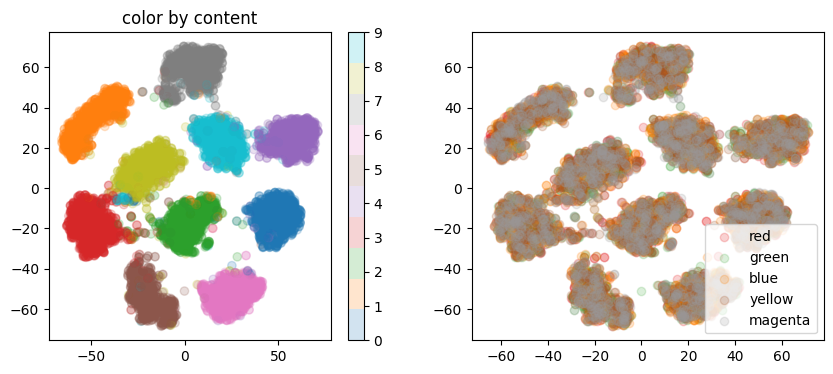

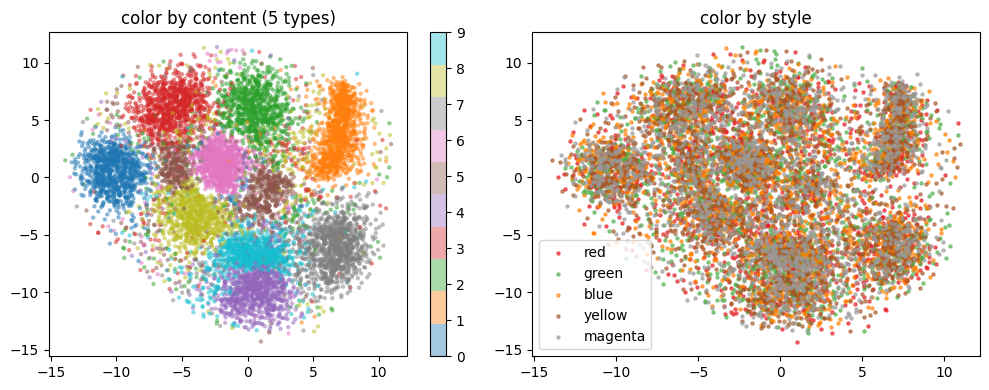

In [20]:
%run script_example.py


In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
mnist = MNIST("./data", train=True, download=False)

In [16]:
np.random.seed(101)
torch.manual_seed(101)

generator = StyledMNISTGenerator(
    mnist,
    {
        # corruptions.identity: 0.1,
        # corruptions.stripe: 0.15,
        # corruptions.zigzag: 0.25,
        # corruptions.canny_edges: 0.15,
        # lambda x: corruptions.scale(x, 5): 0.15,
        # corruptions.brightness: 0.2
        lambda x: corruptions.rgb_change(x, 'red'): 0.2,
        lambda x: corruptions.rgb_change(x, 'green'): 0.2,
        lambda x: corruptions.rgb_change(x, 'blue'): 0.2,
        lambda x: corruptions.rgb_change(x, 'yellow'): 0.2,
        lambda x: corruptions.rgb_change(x, 'magenta'): 0.2,
    },
)
dataset = StyledMNIST(
    generator, 
    transforms.Compose([
        transforms.ToTensor(), 
        lambda img: img / 255.0,
    ])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])

Generating dataset: 100%|██████████| 60000/60000 [00:01<00:00, 38369.30item/s]


In [5]:
import torch.nn as nn
import torch.nn.init as init

def init_weights(m):
    # 卷积层（包括 up/down 里的 Conv2d / ConvTranspose2d）
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.zeros_(m.bias)

    # 全连接层（如果你的 mid / 对比头里有 Linear）
    elif isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)

    # 归一化层
    elif isinstance(m, (nn.GroupNorm, nn.BatchNorm2d, nn.LayerNorm)):
        if m.weight is not None:
            init.ones_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)


def silu_xavier_init(m):
    """SiLU 专用的 Xavier 初始化 - 手动计算 gain"""
    # SiLU gain = ReLU gain * Sigmoid gain ≈ 1.4884
    SILU_GAIN = 1.4884  # √2 * √(π/8)
    
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=SILU_GAIN)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    
    elif isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.xavier_uniform_(m.weight, gain=SILU_GAIN)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

# 现在可以正常运行




In [6]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=256, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [ ]:
params = {
    "lr": 5e-4,
    "optimizer": "Adam",
    "batch_size": 128,
    "channel_split": [3, 12],
    "beta": 1 / 5,
    "gamma_1": 2000,
    "gamma_2": 2000,
    "z_channels": 15,
    "contrastive_module": {
        "contrastive_method": "DenseSNN",
        "temperature": [0.2, 0.2],
        "learnable_temp": True,
        "pool": "gap",
        "use_proj": True,
        "use_dense": False,
    },
}



input_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
output_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

vae = VAE(
    channels=32,
    channel_multipliers=[1, 2, 4],
    n_resnet_blocks=1,
    x_channels=3,
    z_channels=params["z_channels"],
    norm_channels=32,
    n_heads=4,
).to(device)

# vae.apply(init_weights)
vae.apply(silu_xavier_init)


trainer = CLEAR_VAEFirstStageTrainer(
    model=vae,
    early_stopping=EarlyStopping(patience=8),
    verbose_period=2,
    device=device,
    model_signature=signature,
    args={
        "beta": params["beta"],
        "gamma": params["gamma"],
        "vae_lr": params["lr"],
        "channel_split": params["channel_split"],
        "contrastive_module": params["contrastive_module"],
    },
)

In [8]:
mlflow.set_tracking_uri("./mlruns")
mlflow.set_experiment("test")
with mlflow.start_run():
    mlflow.log_params(params)
    trainer.fit(epochs=20, train_loader=train_loader, valid_loader=valid_loader)

/opt/anaconda3/envs/clear312/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
Epoch 0:   2%|▏         | 6/313 [00:02<02:12,  2.31batch/s, con_loss=2.34, dense_con_loss=0, dense_ps_loss=0, kl_loss=1.39e+3, ps_loss=0.107, rec_loss=851]    


KeyboardInterrupt: 

In [19]:
print("content tau:", trainer.contrastive_criterions['global']['content'].log_tau.exp().item())
print("style tau:", trainer.contrastive_criterions['global']['style'].log_tau.exp().item())


content tau: 0.20000000298023224
style tau: 0.20000000298023224


In [20]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

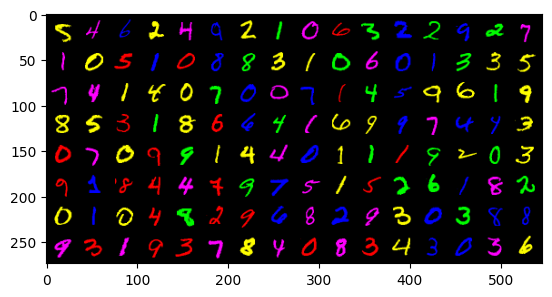

In [ ]:
batch = next(iter(test_loader))
x, y = batch['image'].to(device), batch['label'].to(device)
plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))

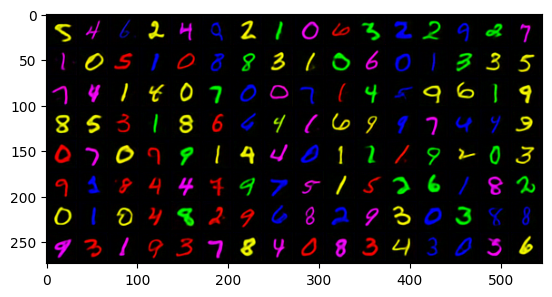

In [66]:
x = next(iter(test_loader))['image'].to("mps")
best_model = mlflow.pytorch.load_model('runs:/daa8d1e129434077aa8c67b4716f5744/best_model')
with torch.no_grad():
    best_model.eval()
    xhat, posterior = best_model(x)
    plt.imshow(make_grid(xhat, nrow=16).cpu().permute(1,2,0))

In [67]:
from mlflow.tracking import MlflowClient

run = MlflowClient().get_run("daa8d1e129434077aa8c67b4716f5744")
channel_split = eval(run.data.params['channel_split'])

torch.Size([128, 15, 8, 8])


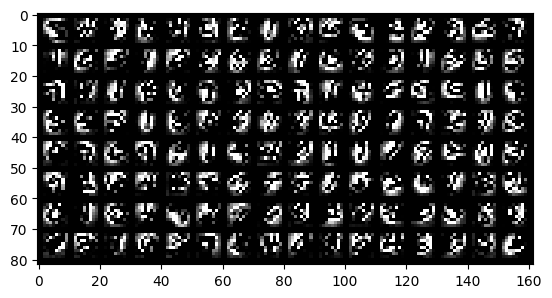

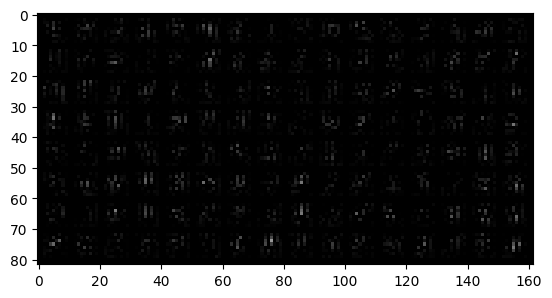

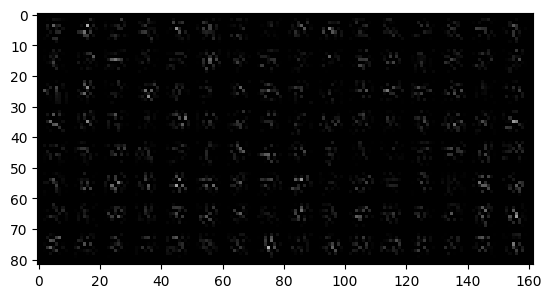

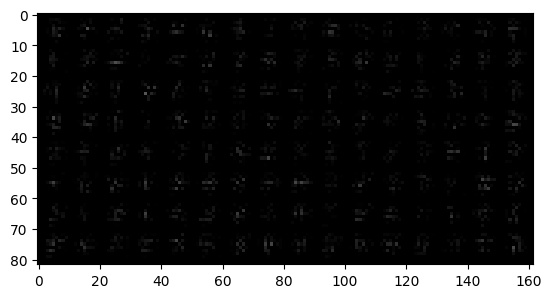

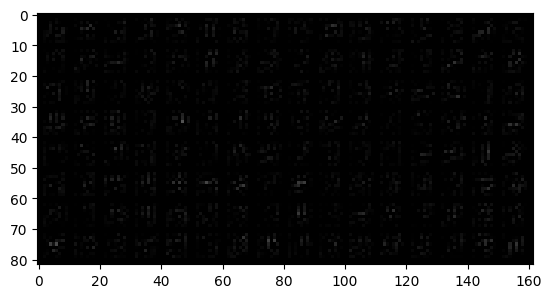

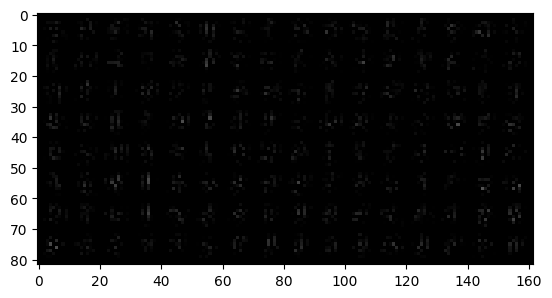

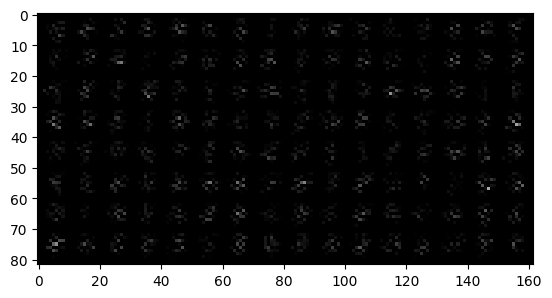

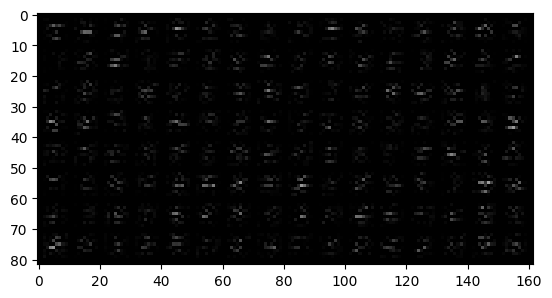

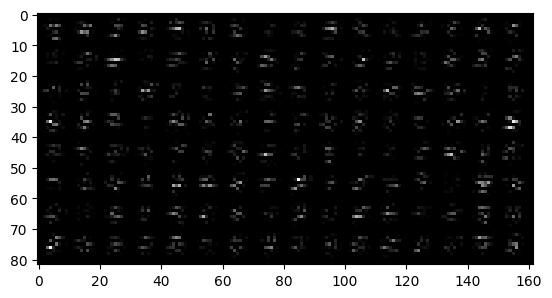

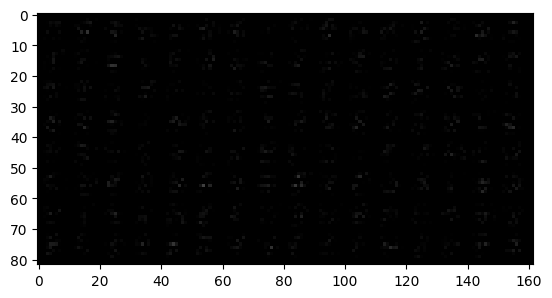

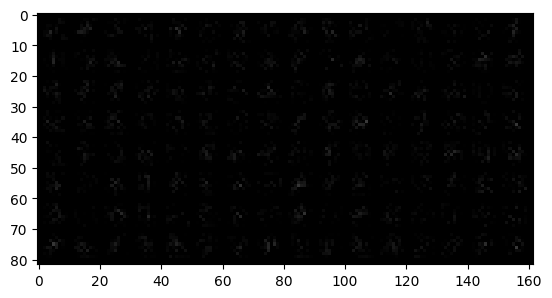

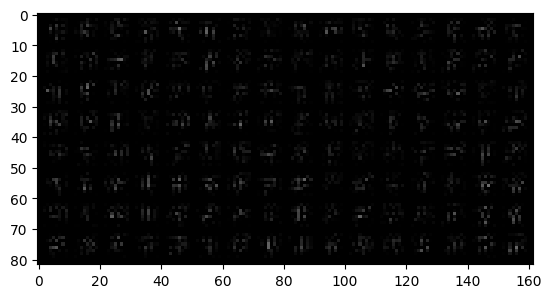

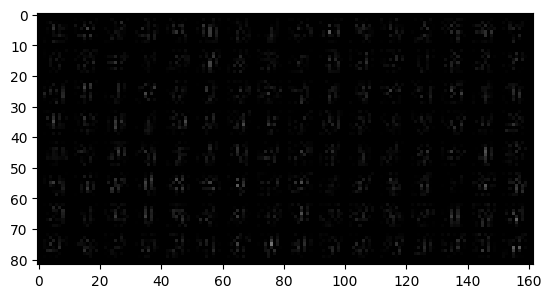

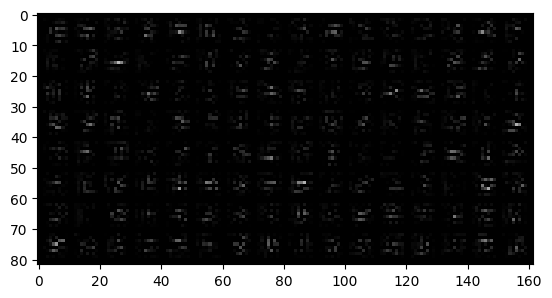

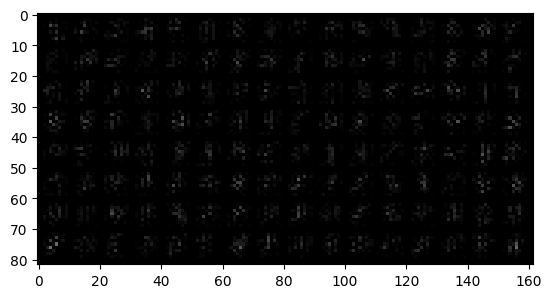

In [68]:
mu = posterior.mu
print(mu.shape)
for i in range(mu.shape[1]):
    plt.imshow(make_grid(mu[:,i][:,None,:,:], nrow=16).cpu().permute(1,2,0))
    plt.show()

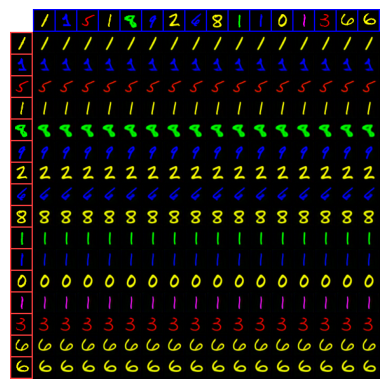

In [ ]:
from exp_utils.visual import feature_swapping_plot

z_c, z_s = mu.split_with_sizes(params['channel_split'], dim=1)
x = next(iter(test_loader))['image'].to(device)

select = torch.randint(0, 128, (16,)).tolist()
feature_swapping_plot(
     z_c[select],
     z_s[select],
     x[select],
     best_model,
)

In [41]:
z_cs = []
z_ss = []
labels = []
styles = []

with torch.no_grad():
    best_model.eval()
    for batch in tqdm(test_loader):
        x = batch['image'].to(device)
        _, posterior = best_model(x)
        z_c, z_s = posterior.sample().split_with_sizes(channel_split, dim=1)
        z_cs.append(z_c.cpu())
        z_ss.append(z_s.cpu())
        labels.append(batch['label'])
        styles.append(batch['style'])

z_cs = torch.cat(z_cs, dim=0)
z_ss = torch.cat(z_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:03<00:00, 21.90it/s]


In [42]:
from sklearn.manifold import TSNE

In [43]:
tsne = TSNE(n_components=2, init='pca')
z_2d = tsne.fit_transform(z_cs.view(z_cs.shape[0], -1).numpy())

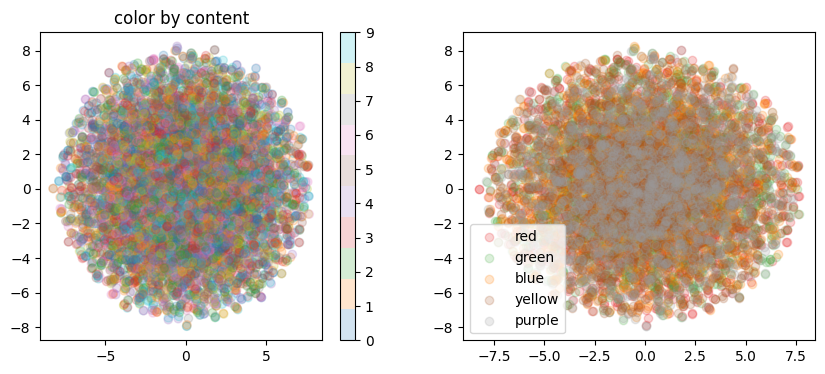

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs0 = axs[0].scatter(z_2d[:, 0], z_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.2)
cbar = fig.colorbar(axs0, ax=axs[0])
axs[0].set_title('color by content')

# style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale','brightness']
style_labels = ['red', 'green', 'blue', 'yellow', 'purple']
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    axs[1].scatter(z_2d[i,0], z_2d[i,1], alpha=0.2, c=colors[g], label=style_labels[g])
axs[1].legend()
plt.show()

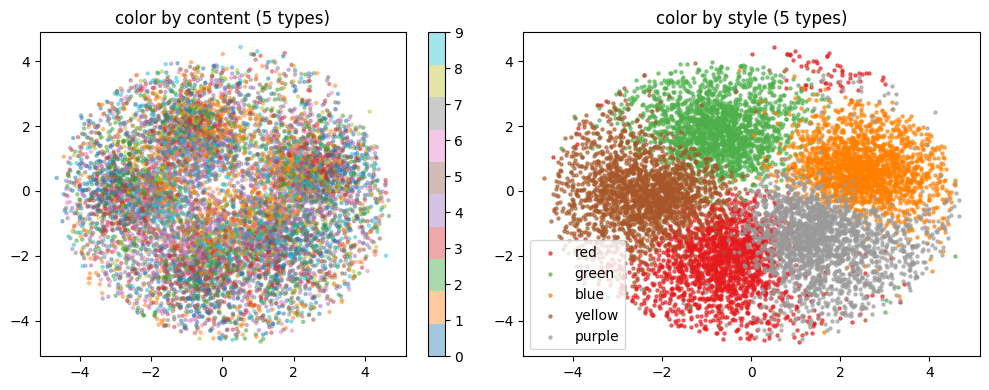

In [ ]:
X = z_ss.view(z_ss.shape[0], -1).cpu().numpy()
y_content = labels.cpu().numpy()
y_style = styles.cpu().numpy()

N = X.shape[0]
idx = np.random.choice(N, size=N, replace=False)

X_sub = X[idx]
content_sub = y_content[idx]
style_sub = y_style[idx]

tsne = TSNE(
    n_components=2,
    init='pca',
    perplexity=100,
    learning_rate=800,
    max_iter=8000,
    early_exaggeration=40,
    random_state=0,
)
z_2d = tsne.fit_transform(X_sub)   

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs0 = axs[0].scatter(
    z_2d[:, 0],
    z_2d[:, 1],
    c=content_sub,        
    cmap='tab10',
    alpha=0.4,
    s=5,
)
cbar = fig.colorbar(axs0, ax=axs[0])
axs[0].set_title('color by content (5 types)')

style_labels = ['red', 'green', 'blue', 'yellow', 'purple']
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

for g in range(len(style_labels)):
    i = np.where(style_sub == g)[0]   
    axs[1].scatter(
        z_2d[i, 0],
        z_2d[i, 1],
        alpha=0.6,
        c=[colors[g]],             
        s=5,
        label=style_labels[g],
    )

axs[1].set_title('color by style (5 types)')
axs[1].legend()
plt.tight_layout()
plt.show()


## 1


In [211]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)
dataset = StyledMNIST(
    generator, 
    transforms.Compose([
        transforms.ToTensor(), 
        lambda img: img / 255.0,
    ])
)



train, test, valid = random_split(dataset, [40000, 10000, 10000])

Generating dataset: 100%|██████████| 60000/60000 [00:09<00:00, 6418.26item/s]


In [127]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=256, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [145]:
params = {
    "lr": 5e-5,
    "optimizer": "Adam",
    "batch_size": 64384,
    "channel_split": [2, 16],
    "beta": 1 / 5,
    "gamma": 10000,
    "z_channels": 18,
    "contrastive_module": {
        "contrastive_method": "SNN",
        "temperature": [0.2, 0.2],
        "learnable_temp": True,
        "pool": "gap",
        "use_proj": True,
        "use_dense": False,
    },
}



input_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
output_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

vae = VAE(
    channels=32,
    channel_multipliers=[1, 2, 4],
    n_resnet_blocks=1,
    x_channels=1,
    z_channels=params["z_channels"],
    norm_channels=32,
    n_heads=4,
).to(device)

trainer = CLEAR_VAEFirstStageTrainer(
    model=vae,
    early_stopping=EarlyStopping(patience=8),
    verbose_period=2,
    device="mps",
    model_signature=signature,
    args={
        "beta": params["beta"],
        "gamma": params["gamma"],
        "vae_lr": params["lr"],
        "channel_split": params["channel_split"],
        "contrastive_module": params["contrastive_module"],
    },
)

In [146]:
mlflow.set_tracking_uri("./mlruns")
mlflow.set_experiment("test")
with mlflow.start_run():
    mlflow.log_params(params)
    trainer.fit(epochs=25, train_loader=train_loader, valid_loader=valid_loader)

Epoch 0:   0%|          | 0/313 [00:00<?, ?batch/s]

100%|██████████| 40/40 [00:03<00:00, 10.91batch/s]


epoch 0/val_rec: 73.0084
[INFO]: track model state


100%|██████████| 40/40 [00:03<00:00, 11.46batch/s]


epoch 2/val_rec: 42.3007
[INFO]: track model state


100%|██████████| 40/40 [00:03<00:00, 11.02batch/s]


epoch 4/val_rec: 38.8329
[INFO]: track model state


100%|██████████| 40/40 [00:03<00:00, 10.69batch/s]


epoch 6/val_rec: 36.5438
[INFO]: track model state


100%|██████████| 40/40 [00:04<00:00,  8.16batch/s]


epoch 8/val_rec: 34.6419
[INFO]: track model state


100%|██████████| 40/40 [00:04<00:00,  8.73batch/s]


epoch 10/val_rec: 33.3926
[INFO]: track model state


100%|██████████| 40/40 [00:04<00:00,  9.08batch/s]


epoch 12/val_rec: 32.9555
[INFO]: track model state


100%|██████████| 40/40 [00:04<00:00,  9.28batch/s]


epoch 14/val_rec: 32.3229
[INFO]: track model state


100%|██████████| 40/40 [00:04<00:00,  9.55batch/s]


epoch 16/val_rec: 32.0816
[INFO]: track model state


100%|██████████| 40/40 [00:04<00:00,  8.53batch/s]


epoch 18/val_rec: 32.1439


100%|██████████| 40/40 [00:04<00:00,  8.59batch/s]


epoch 20/val_rec: 30.6362
[INFO]: track model state


100%|██████████| 40/40 [00:04<00:00,  9.25batch/s]


epoch 22/val_rec: 29.9980
[INFO]: track model state


100%|██████████| 40/40 [00:04<00:00,  9.11batch/s]
2025/12/23 09:49:45 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - torch (current: 2.9.1, required: torch==2.7.1+cu128)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


epoch 24/val_rec: 29.9067
[INFO]: track model state
[INFO]: log best model


In [139]:
print("content tau:", trainer.contrastive_criterions['global']['content'].log_tau.exp().item())
print("style tau:", trainer.contrastive_criterions['global']['style'].log_tau.exp().item())


content tau: 0.14172561466693878
style tau: 0.20000000298023224


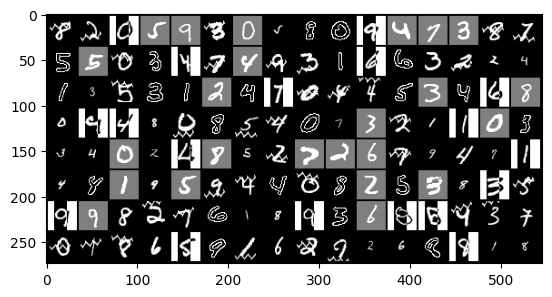

In [140]:
batch = next(iter(test_loader))
x, y = batch['image'].to("mps"), batch['label'].to("mps")
plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))

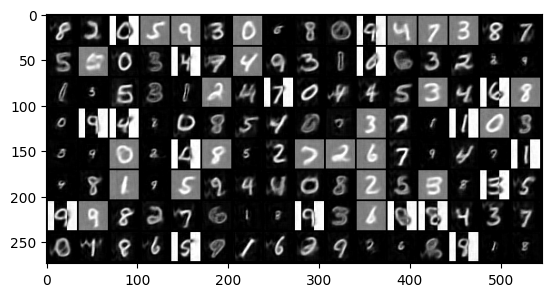

In [147]:
x = next(iter(test_loader))['image'].to("mps")
best_model = mlflow.pytorch.load_model('runs:/2cf7806749354f339f147355ad462fac/best_model')
with torch.no_grad():
    best_model.eval()
    xhat, posterior = best_model(x)
    plt.imshow(make_grid(xhat, nrow=16).cpu().permute(1,2,0))

In [148]:
from mlflow.tracking import MlflowClient

run = MlflowClient().get_run("2cf7806749354f339f147355ad462fac")
channel_split = eval(run.data.params['channel_split'])

torch.Size([128, 18, 8, 8])


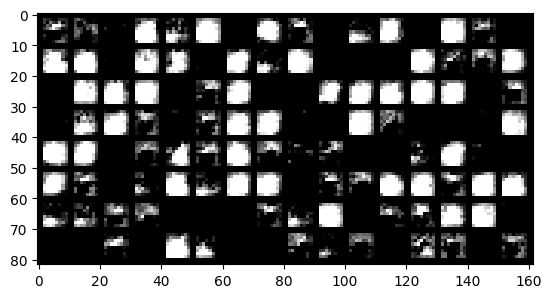

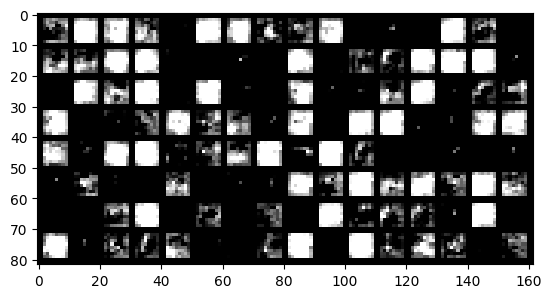

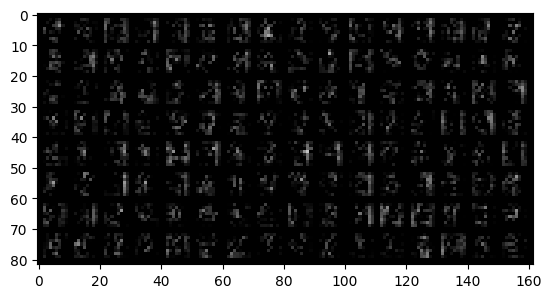

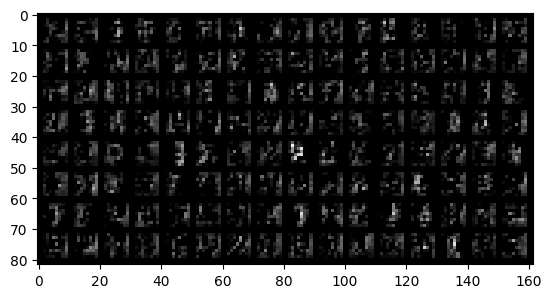

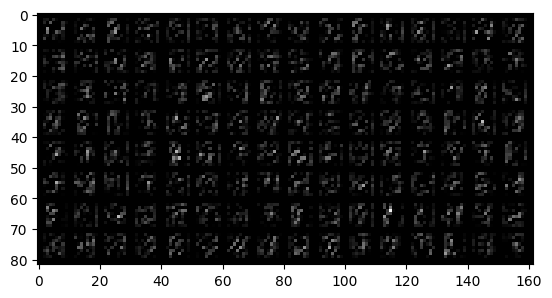

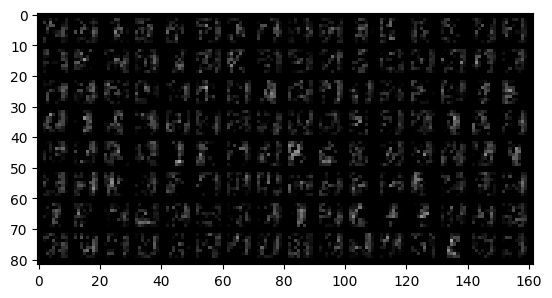

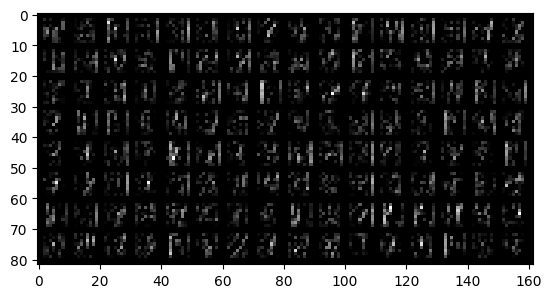

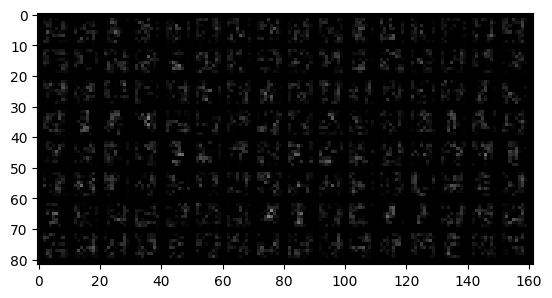

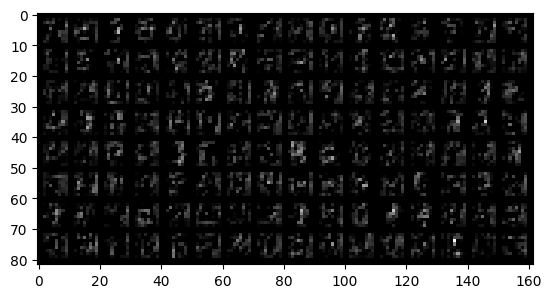

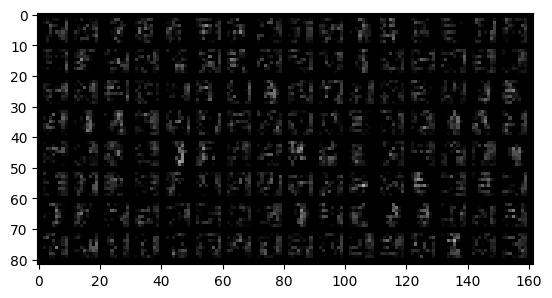

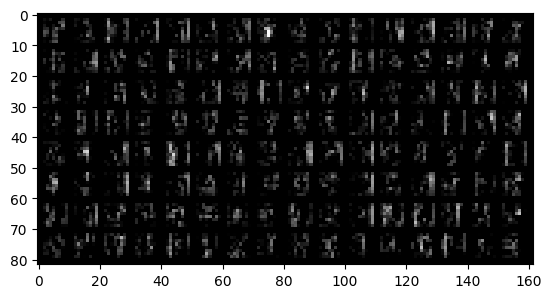

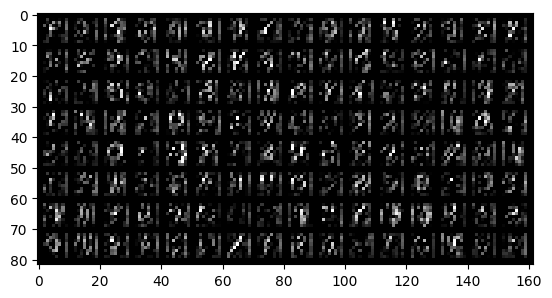

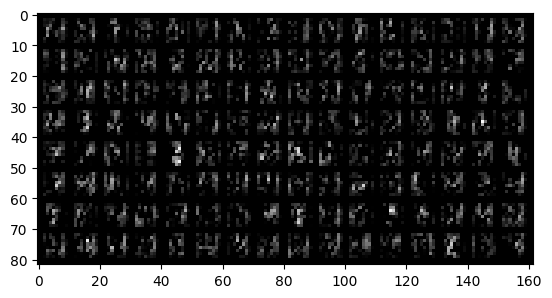

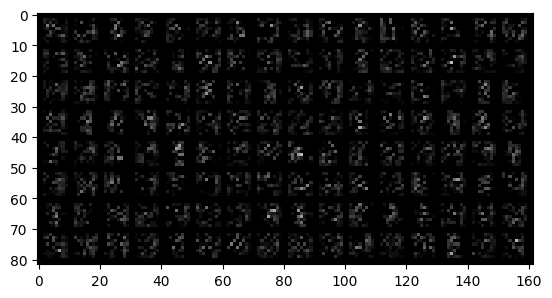

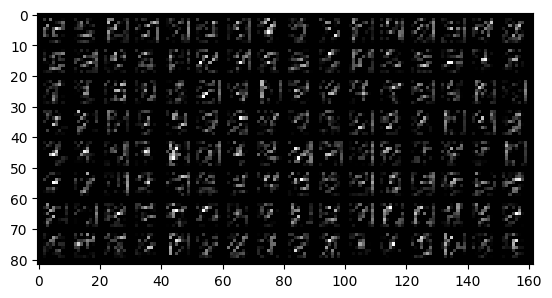

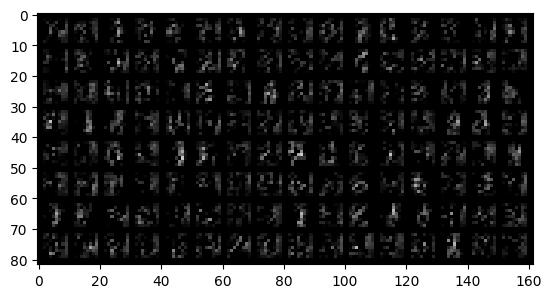

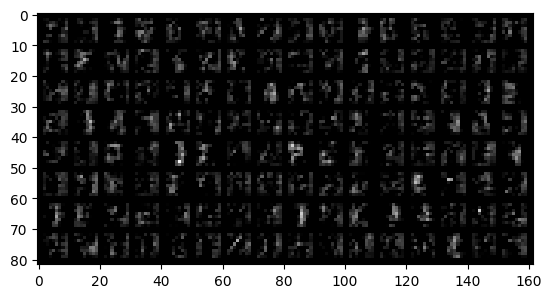

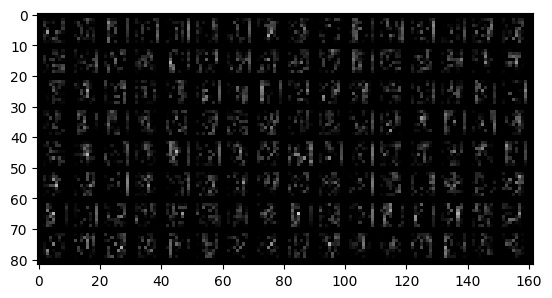

In [149]:
mu = posterior.mu
print(mu.shape)
for i in range(mu.shape[1]):
    plt.imshow(make_grid(mu[:,i][:,None,:,:], nrow=16).cpu().permute(1,2,0))
    plt.show()

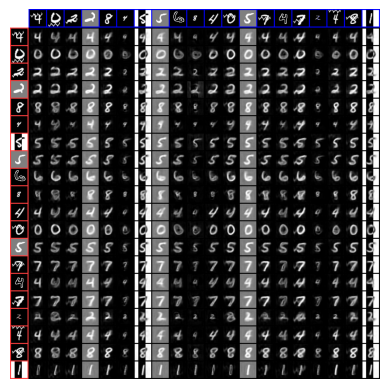

In [150]:
from exp_utils.visual import feature_swapping_plot

z_c, z_s = mu.split_with_sizes(params['channel_split'], dim=1)
x = next(iter(test_loader))['image'].to("mps")

select = torch.randint(0, 128, (20,)).tolist()
feature_swapping_plot(
     z_c[select],
     z_s[select],
     x[select],
     best_model,
)

In [151]:
z_cs = []
z_ss = []
labels = []
styles = []

with torch.no_grad():
    best_model.eval()
    for batch in tqdm(test_loader):
        x = batch['image'].to(device)
        _, posterior = best_model(x)
        z_c, z_s = posterior.sample().split_with_sizes(channel_split, dim=1)
        z_cs.append(z_c.cpu())
        z_ss.append(z_s.cpu())
        labels.append(batch['label'])
        styles.append(batch['style'])

z_cs = torch.cat(z_cs, dim=0)
z_ss = torch.cat(z_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:03<00:00, 21.93it/s]


In [152]:
tsne = TSNE(n_components=2, init='pca')
z_2d = tsne.fit_transform(z_cs.view(z_cs.shape[0], -1).numpy())

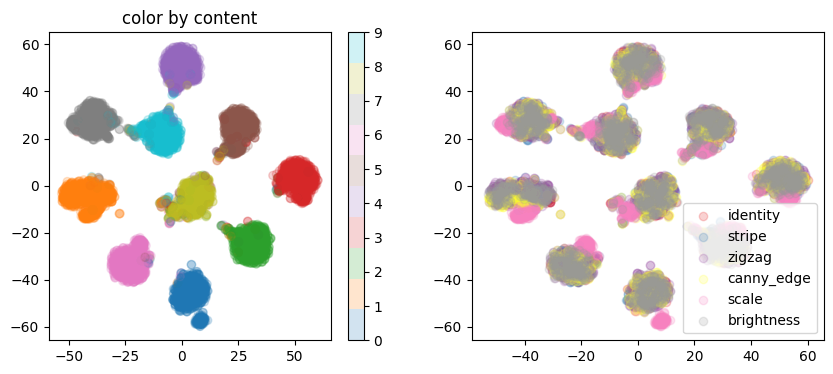

In [153]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs0 = axs[0].scatter(z_2d[:, 0], z_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.2)
cbar = fig.colorbar(axs0, ax=axs[0])
axs[0].set_title('color by content')

style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale','brightness']
# style_labels = ['red', 'green', 'blue', 'yellow', 'purple']
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    axs[1].scatter(z_2d[i,0], z_2d[i,1], alpha=0.2, c=colors[g], label=style_labels[g])
axs[1].legend()
plt.show()

In [154]:
tsne = TSNE(n_components=2, init='pca')
z_2d = tsne.fit_transform(z_ss.view(z_ss.shape[0], -1).numpy())

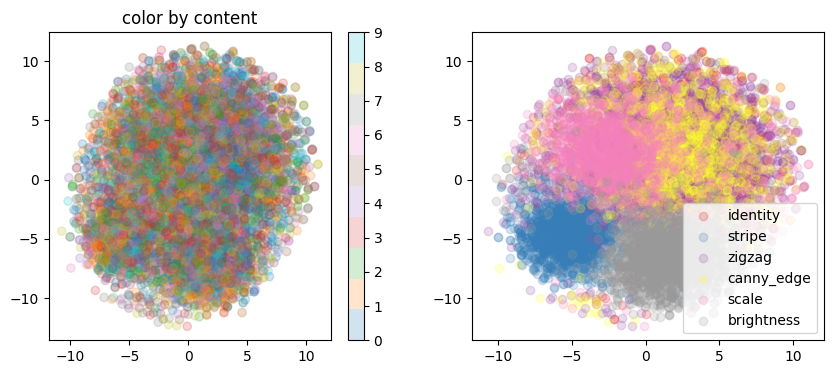

In [156]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs0 = axs[0].scatter(z_2d[:, 0], z_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.2)
cbar = fig.colorbar(axs0, ax=axs[0])
axs[0].set_title('color by content')

style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale','brightness']
# style_labels = ['red', 'green', 'blue', 'yellow', 'purple']
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    axs[1].scatter(z_2d[i,0], z_2d[i,1], alpha=0.2, c=colors[g], label=style_labels[g])
axs[1].legend()
plt.show()